In [38]:
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os
import matplotlib.pyplot as plt
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from skimage import util 
from skimage.transform import resize
from skimage.io import imread
import warnings
warnings.filterwarnings("ignore")

image_resize_px = 64
def showimages(x,coloums=30,row=3,col=True):
    fig=plt.figure(figsize=(30, 3))
    columns = coloums; rows = row
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        if col: plt.imshow(np.squeeze(x[i-1]))
        else:   plt.imshow(np.squeeze(x[i-1]),cmap='gray')
        plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)
        plt.grid(False)
    plt.show()

data_location = "../../Dataset/STL10/img/10/"
train_data = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".png" in filename.lower() :
            train_data.append(os.path.join(dirName,filename))
train_batch = np.zeros(shape=(len(train_data),image_resize_px,image_resize_px,3))
for file_index in range(len(train_data)):
    train_batch[file_index] = resize(imread(train_data[file_index]),(image_resize_px,image_resize_px))
print('Train batch, min, max : ',train_batch.shape,train_batch.min((0,1,2)),train_batch.max((0,1,2)))
train_batch1 = train_batch.copy()

data_location = "../../Dataset/STL10/img/2/"
train_data = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".png" in filename.lower() :
            train_data.append(os.path.join(dirName,filename))
train_batch = np.zeros(shape=(len(train_data),image_resize_px,image_resize_px,3))
for file_index in range(len(train_data)):
    train_batch[file_index] = resize(imread(train_data[file_index]),(image_resize_px,image_resize_px))
print('Train batch, min, max : ',train_batch.shape,train_batch.min((0,1,2)),train_batch.max((0,1,2)))
train_batch2 = train_batch.copy()

data_location = "../../Dataset/STL10/img/1/"
train_data = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".png" in filename.lower() :
            train_data.append(os.path.join(dirName,filename))
train_batch = np.zeros(shape=(len(train_data),image_resize_px,image_resize_px,3))
for file_index in range(len(train_data)):
    train_batch[file_index] = resize(imread(train_data[file_index]),(image_resize_px,image_resize_px))
print('Train batch, min, max : ',train_batch.shape,train_batch.min((0,1,2)),train_batch.max((0,1,2)))
train_batch3 = train_batch.copy()

Train batch, min, max :  (500, 64, 64, 3) [0. 0. 0.] [1. 1. 1.]
Train batch, min, max :  (500, 64, 64, 3) [0. 0. 0.] [1. 1. 1.]
Train batch, min, max :  (500, 64, 64, 3) [0. 0. 0.] [1. 1. 1.]


(1500, 64, 64, 3)


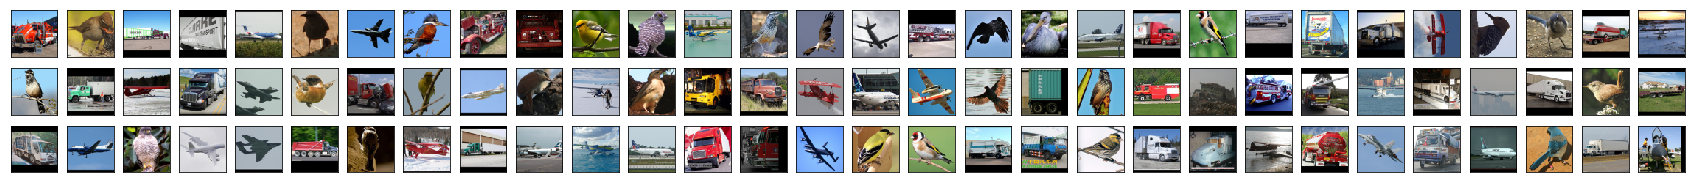

In [56]:
# show the random images
from sklearn.utils import shuffle
train_batch_final = np.vstack((train_batch1,train_batch2,train_batch3))
train_batch_final = shuffle(train_batch_final)
print(train_batch_final.shape)
showimages(shuffle(train_batch_final[:100]))

# a. Batch Normalization Layer

In [ ]:
# test out the mean layer (reset the graph)
tf.reset_default_graph()
class tf_batch_norm_layer():
    
    def __init__(self,vector_shape):
        self.moving_mean = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float64))
        self.moving_vari = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float64))
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value
        
        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=(0,1,2),keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=(0,1,2),keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad):
        return grad - 1.0/grad.shape[1].value
    
# make the place holder and start the session
x     = tf.placeholder(shape=(100,64,64,3),dtype=tf.float64)
phase = tf.placeholder(shape=[],dtype=tf.bool)

batch_norm_layer               = tf_batch_norm_layer(3)
batch_norm_data,update_mov_var = batch_norm_layer.feedforward(x,training_phase=phase)

sess = tf.InteractiveSession();  sess.run(tf.global_variables_initializer())
mean_result,mean_update = sess.run([batch_norm_data,update_mov_var],feed_dict={x:train_batch_final[:100],phase:True})

# print('Before Mean Layer : ',train_batch_final[:100,:,:,:].mean(-1).sum());  print('After  Mean Layer : ',mean_result.mean(-1).sum())
# print('Data    Mean : ',     train_batch_final[:100,:,:,:].mean());          print('Updated Mean : ',     mean_update.mean())
# print('Gradient of Mean: ',  mean_gradient.mean() )

mean_result = (mean_result-mean_result.min((1,2),keepdims=True))/(mean_result.max((1,2),keepdims=True)-mean_result.min((1,2),keepdims=True))
showimages(mean_result,col=True)